In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from data_analysis import run_tsne, plot_tsne

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import shap

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, LeaveOneOut, RepeatedStratifiedKFold

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [6]:
data_source = 'C:/Users/BiSBII/Documents/MM_ML/data/'

In [7]:
dataset_file = os.path.join(data_source, 'GREAT_TPM_GSE98923.csv')
metadata_file = os.path.join(data_source, 'GSE98923_metadata.xlsx')

In [8]:
metadata_reps = pd.read_excel(metadata_file, index_col=0)
metadata_reps.shape

(220, 19)

In [9]:
metadata_noreps = pd.read_excel(metadata_file, index_col=0, sheet_name='NO_REPLICATES')
metadata_noreps.shape

(73, 3)

In [10]:
y_state_noreps = metadata_noreps['state']

## data with replicates and all genes

In [11]:
data_all = pd.read_csv(os.path.join(data_source, 'GREAT_LOG_TPM_GSE98923.csv'), index_col=0)
data_all = data_all.transpose()
data_all.shape

(218, 35336)

In [12]:
y_state_reps = metadata_reps['state'][data_all.index]

## 3) data without replicates and all genes

In [13]:
data_noreps = pd.read_csv(os.path.join(data_source, 'GREAT_LOG_TPM_GSE98923_NOREPS.csv'), index_col=0)
data_noreps = data_noreps.transpose()
data_noreps.shape

(73, 35336)

# UNSUPERVISED

In [14]:
vt = VarianceThreshold(0.1)
data_filtered = vt.fit_transform(data_all)
cols_inds = vt.get_support(indices=True)
df_data_filtered = pd.DataFrame(data_filtered, index=data_all.index, columns=data_all.columns[cols_inds])
df_data_filtered.shape

(218, 18254)

In [15]:
df_tsne = run_tsne(n_components=2, data=df_data_filtered)

In [16]:
df_tsne['factor'] = y_state_reps

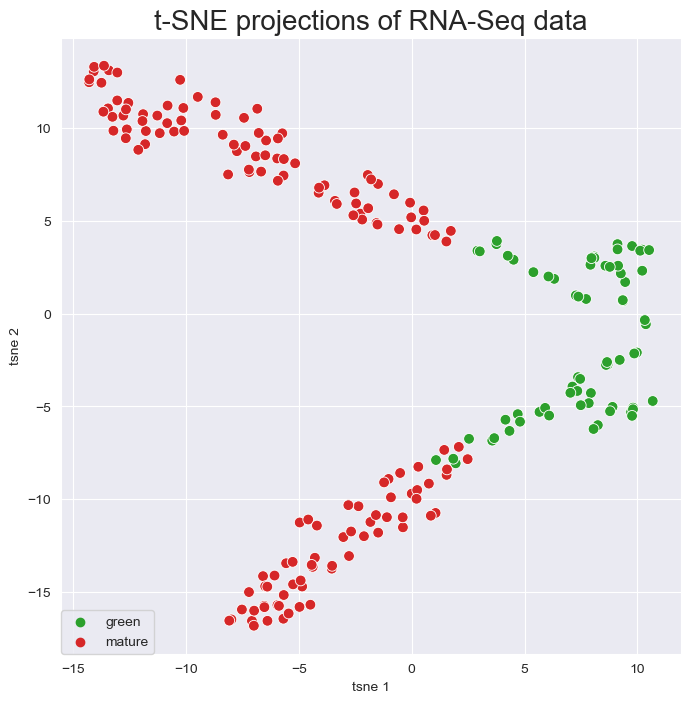

In [18]:
plot_tsne(data=df_tsne, name_fig='tsne_RNASeq_all_genes_reps', title='t-SNE projections of RNA-Seq data')

# SUPERVISED ANALYSIS - CV

In [19]:
binary = {'green': 0, 'mature': 1}
binary_output = y_state_noreps.map(binary)

In [20]:
scaler = StandardScaler()
vt = VarianceThreshold(0.001)
skb = SelectKBest(f_classif, k=500)
scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1, n_repeats=10)

use the dataset without replicates

In [21]:
data = data_noreps.copy() 

## LR

In [22]:
lr_cv = LogisticRegression()

pipe_lr = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', lr_cv)])

scores_lr = cross_validate(pipe_lr, data, binary_output, cv=cv, scoring=scoring)

print('test_accuracy', round(scores_lr['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_lr['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_lr['test_precision'].mean(), 2))
print('test_recall', round(scores_lr['test_recall'].mean(), 2))
print('test_f1', round(scores_lr['test_f1'].mean(), 2))

test_accuracy 0.96
test_balanced_accuracy 0.96
test_precision 0.96
test_recall 0.98
test_f1 0.97


## RF

In [27]:
rf_cv = RandomForestClassifier(random_state=1)

pipe_rf = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', rf_cv)])

scores_rf = cross_validate(pipe_rf, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_rf['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_rf['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_rf['test_precision'].mean(), 2))
print('test_recall', round(scores_rf['test_recall'].mean(), 2))
print('test_f1', round(scores_rf['test_f1'].mean(), 2))

test_accuracy 0.97
test_balanced_accuracy 0.97
test_precision 0.97
test_recall 0.98
test_f1 0.97


## KNN

In [23]:
knn_cv = KNeighborsClassifier()

pipe_knn = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', knn_cv)])

scores_knn = cross_validate(pipe_knn, data, binary_output, cv=cv, scoring=scoring)
for key in scores_knn:
    print(key, round(scores_knn[key].mean(), 2))

fit_time 2.46
score_time 1.22
test_accuracy 0.97
test_balanced_accuracy 0.97
test_precision 0.96
test_recall 1.0
test_f1 0.98


## DT

In [24]:
tree_cv = tree.DecisionTreeClassifier(random_state=1)

pipe_tree = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', tree_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_tree = cross_validate(pipe_tree, data, binary_output, cv=cv, scoring=scoring)
for key in scores_tree:
    print(key, round(scores_tree[key].mean(), 2))

fit_time 2.44
score_time 1.2
test_accuracy 0.96
test_balanced_accuracy 0.96
test_precision 0.97
test_recall 0.96
test_f1 0.96


## SVM

In [25]:
svm_cv = svm.SVC()

pipe_svm = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', svm_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_svm = cross_validate(pipe_svm, data, binary_output, cv=cv, scoring=scoring)
for key in scores_svm:
    print(key, round(scores_svm[key].mean(), 2))

fit_time 2.46
score_time 1.21
test_accuracy 0.98
test_balanced_accuracy 0.97
test_precision 0.97
test_recall 1.0
test_f1 0.98


## SVM LINEAR

In [26]:
svm_l_cv = svm.SVC(kernel='linear')

pipe_svm_l = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', svm_l_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_svm_l = cross_validate(pipe_svm_l, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_svm_l['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_svm_l['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_svm_l['test_precision'].mean(), 2))
print('test_recall', round(scores_svm_l['test_recall'].mean(), 2))
print('test_f1', round(scores_svm_l['test_f1'].mean(), 2))

test_accuracy 0.96
test_balanced_accuracy 0.95
test_precision 0.96
test_recall 0.97
test_f1 0.96


# SHAP VALUES

## KNN

In [28]:
CV_repeats = 10
cv_repeated = RepeatedStratifiedKFold(n_splits=10, random_state=1, n_repeats=10)
scores_knn = {'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

scaler = StandardScaler()
vt = VarianceThreshold(0.001)
skb = SelectKBest(f_classif, k=500)

In [29]:
shap_values_per_cv_knn = dict()
for sample in data.index:
    shap_values_per_cv_knn[sample] = {} 
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv_knn[sample][CV_repeat] = {}

In [30]:
rep = 0    
for i, (train_index, test_index) in enumerate(cv_repeated.split(data, binary_output)):

    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]

    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]

    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    kb2_fit = skb.fit(X_train_filtered, y_train)

    train_filtered2 = kb2_fit.transform(X_train_filtered)
    test_filtered2 = kb2_fit.transform(X_test_filtered)

    cols_inds = kb2_fit.get_support(indices=True)

    X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)

    X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)

    features_selected = X_train_filtered.columns[cols_inds]

    scaler_model = StandardScaler().fit(X_train_filtered2)
    X_train_scaled = scaler_model.transform(X_train_filtered2)
    X_test_scaled = scaler_model.transform(X_test_filtered2)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)

    knn = KNeighborsClassifier()

    knn.fit(X_train_final, y_train)

    knn_y_pred = knn.predict(X_test_final.values)

    scores_knn['accuracy'].append(accuracy_score(y_test, knn_y_pred))
    scores_knn['balanced_accuracy'].append(balanced_accuracy_score(y_test, knn_y_pred))
    scores_knn['precision'].append(precision_score(y_test, knn_y_pred))
    scores_knn['recall'].append(recall_score(y_test, knn_y_pred))
    scores_knn['f1'].append(f1_score(y_test, knn_y_pred))

    explainer = shap.Explainer(knn.predict, X_test_final, max_evals=1100, seed=42)
    shap_values = explainer(X_test_final.values)
    
    df = pd.DataFrame(shap_values.values, columns=features_selected, index=[data.index[i] for i in test_index])
    for ind in df.index:
        shap_values_per_cv_knn[ind][rep] = df.loc[[ind]]
    
    splits = [9, 19, 29, 39, 49, 59, 69, 79, 89]
    if i in splits:
        rep += 1
    
print('accuracy', round(np.array(scores_knn['accuracy']).mean(), 2))
print('balanced_accuracy', round(np.array(scores_knn['balanced_accuracy']).mean(), 2))
print('precision', round(np.array(scores_knn['precision']).mean(), 2))
print('recall', round(np.array(scores_knn['recall']).mean(), 2))
print('f1', round(np.array(scores_knn['f1']).mean(), 2))

accuracy 0.97
balanced_accuracy 0.97
precision 0.96
recall 1.0
f1 0.98


In [31]:
average_shap_values_knn = []

for sample in shap_values_per_cv_knn:
    sample_dfs = [shap_values_per_cv_knn[sample][rep] for rep in shap_values_per_cv_knn[sample]]
    concat_df = pd.concat(sample_dfs, axis=0)
    concat_df = concat_df.fillna(0)
    mean_df = concat_df.mean(axis=0)
    mean_df.name = sample
    average_shap_values_knn.append(mean_df)

In [32]:
concat_mean_knn = pd.concat(average_shap_values_knn, axis=1).transpose()
concat_mean_knn = concat_mean_knn.fillna(0)
concat_mean_knn.shape

(73, 892)

In [33]:
final_shap_array_knn = np.array(concat_mean_knn)

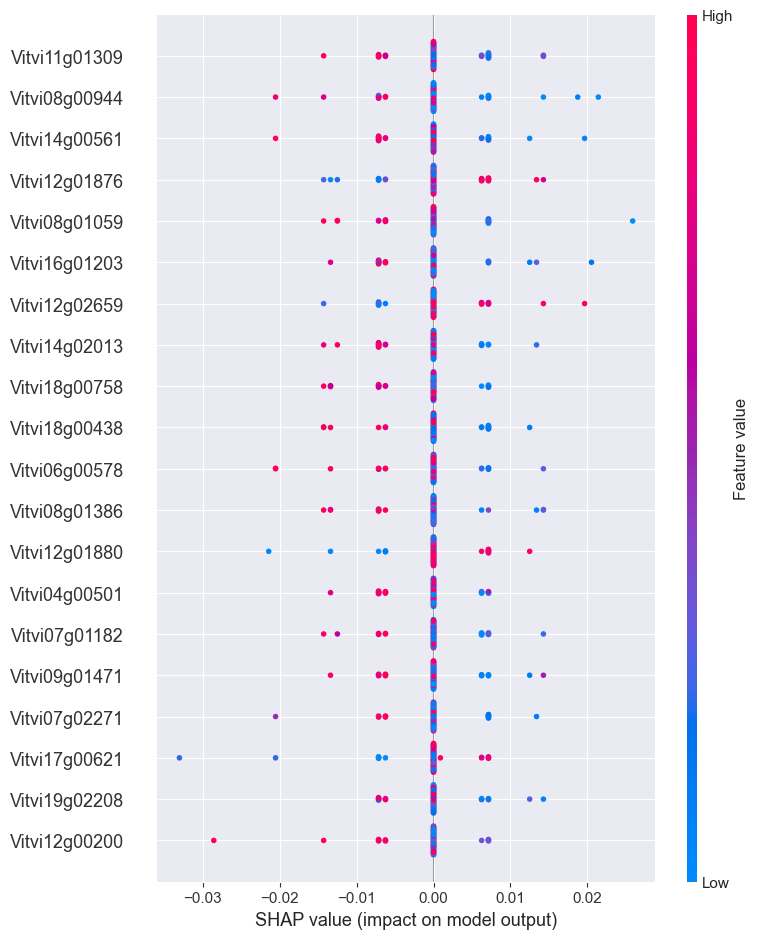

In [43]:
shap.summary_plot(final_shap_array_knn, data[concat_mean_knn.columns])

## SVM

In [49]:
scores_svm = {'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

In [50]:
shap_values_per_cv_svm = dict()
for sample in data.index:
    shap_values_per_cv_svm[sample] = {} 
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv_svm[sample][CV_repeat] = {}

In [51]:
rep = 0    
for i, (train_index, test_index) in enumerate(cv_repeated.split(data, binary_output)):
    
    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]

    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]

    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    kb2_fit = skb.fit(X_train_filtered, y_train)

    train_filtered2 = kb2_fit.transform(X_train_filtered)
    test_filtered2 = kb2_fit.transform(X_test_filtered)

    cols_inds = kb2_fit.get_support(indices=True)

    X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)

    X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)

    features_selected = X_train_filtered.columns[cols_inds]

    scaler_model = StandardScaler().fit(X_train_filtered2)
    X_train_scaled = scaler_model.transform(X_train_filtered2)
    X_test_scaled = scaler_model.transform(X_test_filtered2)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)
    
    svm_model = svm.SVC()

    svm_model.fit(X_train_final, y_train)

    svm_y_pred = svm_model.predict(X_test_final)

    scores_svm['accuracy'].append(accuracy_score(y_test, svm_y_pred))
    scores_svm['balanced_accuracy'].append(balanced_accuracy_score(y_test, svm_y_pred))
    scores_svm['precision'].append(precision_score(y_test, svm_y_pred))
    scores_svm['recall'].append(recall_score(y_test, svm_y_pred))
    scores_svm['f1'].append(f1_score(y_test, svm_y_pred))

    explainer = shap.Explainer(svm_model.predict, X_test_final, max_evals=1100, seed=42)
    shap_values = explainer(X_test_final)
    
    df = pd.DataFrame(shap_values.values, columns=features_selected, index=[data.index[i] for i in test_index])
    for ind in df.index:
        shap_values_per_cv_svm[ind][rep] = df.loc[[ind]]
    
    splits = [9, 19, 29, 39, 49, 59, 69, 79, 89]
    if i in splits:
        rep += 1
    
print('accuracy', round(np.array(scores_svm['accuracy']).mean(), 2))
print('balanced_accuracy', round(np.array(scores_svm['balanced_accuracy']).mean(), 2))
print('precision', round(np.array(scores_svm['precision']).mean(), 2))
print('recall', round(np.array(scores_svm['recall']).mean(), 2))
print('f1', round(np.array(scores_svm['f1']).mean(), 2))

accuracy 0.98
balanced_accuracy 0.97
precision 0.97
recall 1.0
f1 0.98


In [52]:
average_shap_values_svm = []

for sample in shap_values_per_cv_svm:
    sample_dfs = [shap_values_per_cv_svm[sample][rep] for rep in shap_values_per_cv_svm[sample]]
    concat_df = pd.concat(sample_dfs, axis=0)
    concat_df = concat_df.fillna(0)
    mean_df = concat_df.mean(axis=0)
    mean_df.name = sample
    average_shap_values_svm.append(mean_df)

In [53]:
concat_mean_svm = pd.concat(average_shap_values_svm, axis=1).transpose()
concat_mean_svm = concat_mean_svm.fillna(0)
concat_mean_svm.shape

(73, 892)

In [54]:
final_shap_array_svm = np.array(concat_mean_svm)

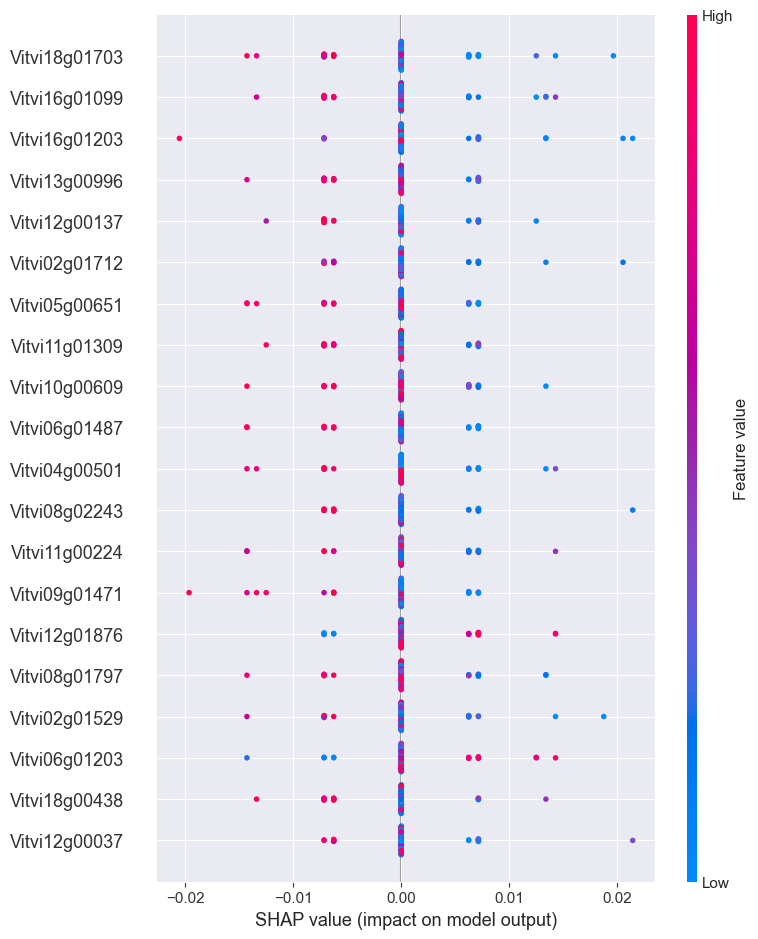

In [55]:
shap.summary_plot(final_shap_array_svm, data[concat_mean_svm.columns])